# Interpretability Assignment

Language models are trained to predict tokens given other tokens. More specifically, the autoregressive Language Modelling objective is given by the following distribution:

$$
P(w_{t} \mid w_{t-1}, w_{t-2} \dots w_0)
$$

The standard Transformer-based Language Model sees tokens as the lowest granularity of language. It sees tokens as entities and predicts other tokens. These models are not given the spelling of a token explicitly.

The question we ask in this assignment is, "to what extent do the representations of words from an LM encode character information?"

"What is it about the Language Modelling objective that allows a model to deduce something about the characters of a token?"


To accomplish our purposes, we will conduct probing studies.
- design a task that relies on the spelling of a word.
- check if a thin (one layer) classifier can be trained on top of LM embeddings to do this task.
- design a control to check whether the task is too easy.

In [2]:
import torch

## Initializing the model

We will be studying a pretrained RoBERTa model. Run the cell below to initialize it.

In [3]:
# loading a small model

from transformers import AutoTokenizer, AutoModel, AutoConfig

config = AutoConfig.from_pretrained("roberta-base")
model = AutoModel.from_pretrained("roberta-base", config=config)
model.eval()
model.cuda()
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

## Example tokenization

Any input text given to the model is first toknized. Typically this is sub-word tokenization i.e. words are broken down further.

A sub subword is the most atomic input given to a language model. For example.

In [3]:
sentence = "This is an example tokenization"
tokenizer.tokenize(sentence)

['This', 'Ġis', 'Ġan', 'Ġexample', 'Ġtoken', 'ization']

As can be seen above, the word "tokenzation" has been broken down into "token" and "ization"

There is no explicit granulairity more than this. In other words, the model __does not directly__ see letters of a word.

The Language Model is trained to predict the next token given the previous tokens. Should this give it a sense of what letters exist in that token?

## Experiment 1

Can the model do something simple like distinguish between capitalized and non-capitalized words?

In other words, we ask if there is a reliable signal in the representations from the model for us to be able to predict whether a word is capitalized or not.

### Q1.1 Make appropriate dataset

In [4]:
!git clone https://github.com/dwyl/english-words.git

Cloning into 'english-words'...
remote: Enumerating objects: 248, done.
remote: Counting objects: 100% (125/125), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 248 (delta 97), reused 83 (delta 83), pack-reused 123
Receiving objects: 100% (248/248), 27.63 MiB | 27.10 MiB/s, done.
Resolving deltas: 100% (117/117), done.


In [5]:
words_list = []
with open("english-words/words_alpha.txt") as f:
    for line in f:
        words_list.append(line.strip())


Take the word list and phrase a classification problem to check the above sub-task:

- Make a train set
- Make a validation set
- Make a test set

In [6]:
word_list_small = [word.lower() for word in words_list]
dataset = []

label = 0
import random
for i, word in enumerate(word_list_small):
    if random.random() > 0.5:
        label = 1
        word = word.capitalize()
    else:
        label = 0
    dataset.append((word, label,))

In [7]:
from sklearn.model_selection import train_test_split
# split into three
train, test = train_test_split(dataset, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)

In [8]:
def check_train_val_test_splits(train, val, test):
    assert len(train) > 0
    assert len(val) > 0
    assert len(test) > 0
    train_set = set(train)
    val_set = set(val)
    test_set = set(test)
    assert len(train_set.intersection(val_set)) == 0
    assert len(train_set.intersection(test_set)) == 0
    assert len(val_set.intersection(test_set)) == 0
    print("All checks passed")


# pass your datasets here
check_train_val_test_splits(train, val, test)

All checks passed


In [9]:
DEVICE = "cuda"

### Get the embeddings from the model for those words

In [10]:
def get_embeddings_all_layers(model, tokenizer, data, pool_func, layer=-1,):
    embed_list = []
    for word, label in data:
        # print(word)
        inputs = tokenizer(word, return_tensors="pt").to(device=DEVICE)
        # print(inputs)
        embeddings = model(**inputs, output_hidden_states=True)
        # embeddings = torch.stack(outputs.hidden_states).squeeze()
        embeddings = embeddings.hidden_states[layer].detach().cpu().numpy()
        embeddings = pool_func(embeddings, dim=-2)
        # print(embeddings.shape)
        embed_list.append(embeddings)
    return embed_list

In [11]:
import torch
import numpy as np


# randomly chose 50% of the train data
train_small = random.sample(train, int(len(train) * 0.005))
test_small = random.sample(test, int(len(train) * 0.005))


embeds = get_embeddings_all_layers(model, tokenizer, train_small, pool_func=lambda x, dim: np.mean(x, axis=dim), layer=-1)
embeds_test = get_embeddings_all_layers(model, tokenizer, test_small, pool_func=lambda x, dim: np.mean(x, axis=dim), layer=-1)


assert embeds[0].shape[-1] == config.hidden_size


In [12]:
# concatenate the embeddings
embeds = np.concatenate(embeds, axis=0)
embeds_test = np.concatenate(embeds_test, axis=0)

In [13]:
embeds

array([[-0.01021133,  0.06039903,  0.03150121, ...,  0.05272496,
        -0.02185433, -0.04844573],
       [-0.04091341,  0.01055863,  0.01710375, ..., -0.1116055 ,
        -0.03074742,  0.04124694],
       [ 0.00461452,  0.1775925 , -0.04015317, ..., -0.01314882,
         0.06834413, -0.15109256],
       ...,
       [-0.01085418,  0.11937785,  0.03584519, ..., -0.10338829,
        -0.11564966, -0.00783099],
       [-0.00175118,  0.03893377, -0.01880038, ..., -0.10808038,
        -0.02732598, -0.06182551],
       [-0.06351298,  0.1287729 ,  0.02109555, ..., -0.24021253,
        -0.09345898, -0.03108136]], dtype=float32)

### Make a classifier

In [13]:
from sklearn.linear_model import LogisticRegression

In [14]:
log_regress = LogisticRegression(max_iter=1000)
log_regress.fit(embeds, [train_small[i][1] for i in range(len(train_small))])

LogisticRegression(max_iter=1000)

In [15]:
from sklearn.metrics import classification_report

In [16]:
print(classification_report([test_small[i][1] for i in range(len(test_small))], log_regress.predict(embeds_test)))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       564
           1       0.99      0.99      0.99       620

    accuracy                           0.99      1184
   macro avg       0.99      0.99      0.99      1184
weighted avg       0.99      0.99      0.99      1184



## Extracting specific letter information from encodings

Check if the model embeddings encode information about the _first_ letter of a word.

Code up the experiment for this

- Make a balanced dataset __[4]__
- Train a classifier __[2]__
- Print a  classification report __[2]__


In [19]:
import random
from collections import defaultdict

def create_balanced_first_letter_dataset(words, num_samples_per_letter):
    dataset = []
    letter_counts = defaultdict(int)

    for word in words:
        first_letter = word[0].lower()  # Normalize to lowercase
        if letter_counts[first_letter] < num_samples_per_letter:
            label = ord(first_letter) - ord('a')  # Map letters to labels (a -> 0, b -> 1, etc. )
            dataset.append((word, label))
            letter_counts[first_letter] += 1

    random.shuffle(dataset)  # Shuffle for randomness
    return dataset

dataset = create_balanced_first_letter_dataset(words_list, num_samples_per_letter=100)

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Split the dataset (consider stratified splitting for future experiments)
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=42)

# Obtain embeddings for the train and test sets
train_embeds = get_embeddings_all_layers(model, tokenizer, X_train, pool_func=lambda x, dim: np.mean(x, axis=dim))
test_embeds = get_embeddings_all_layers(model, tokenizer, X_test, pool_func=lambda x, dim: np.mean(x, axis=dim))

# concatenate the embeddings
train_embeds = np.concatenate(train_embeds, axis=0)
test_embeds = np.concatenate(test_embeds, axis=0)

# Train the classifier
classifier = LogisticRegression(max_iter=1000)
classifier.fit(train_embeds, [X_train[i][1] for i in range(len(X_train))])

LogisticRegression(max_iter=1000)

In [21]:
print(classification_report([X_test[i][1] for i in range(len(X_test))], classifier.predict(test_embeds)))

              precision    recall  f1-score   support

           0       0.70      0.54      0.61        13
           1       0.94      0.89      0.92        19
           2       1.00      1.00      1.00        15
           3       1.00      1.00      1.00        27
           4       0.58      0.95      0.72        19
           5       1.00      0.73      0.84        22
           6       1.00      0.94      0.97        18
           7       0.91      1.00      0.95        20
           8       0.85      0.76      0.80        29
           9       0.77      0.74      0.76        23
          10       0.95      0.95      0.95        22
          11       0.84      0.91      0.87        23
          12       0.96      1.00      0.98        24
          13       1.00      1.00      1.00        22
          14       0.95      0.75      0.84        24
          15       1.00      0.88      0.93        16
          16       1.00      0.83      0.90        23
          17       0.93    

## Do we need 'real' words?

Devise an experiment to check if the model is using semantic information to make its predictions (and not some direct notion of spelling)

- Design an experiment to make it impossible for the semantics to be used in the above task. __[4]__
- Make a dataset for it __[2]__
- Learn a classifier for it __[1]__
- Do the analysis across layers __[3]__

In [25]:
import string
import random

def generate_random_word(length, start_letter):
  return start_letter + ''.join(random.choice(string.ascii_lowercase) for _ in range(length))

def create_pseudowords_dataset(num_samples_per_letter):
    dataset = []

    for i in range(26):
        first_letter = chr(ord('a')+i)
        for _ in range(num_samples_per_letter):
          word_length = random.randint(3, 21)
          word = generate_random_word(word_length, first_letter)
          dataset.append((word, i))

    random.shuffle(dataset)
    return dataset

pseudo_dataset = create_pseudowords_dataset(num_samples_per_letter=100)

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Split the dataset (consider stratified splitting for future experiments)
X_train, X_test = train_test_split(pseudo_dataset, test_size=0.2, random_state=42)

print(model.config.num_hidden_layers)
accuracies = []
recalls = []
f1s = []
precisions = []

for layer_num in range(model.config.num_hidden_layers):  # Iterate through Roberta layers
    # Obtain embeddings for the train and test sets
    train_embeds = get_embeddings_all_layers(model, tokenizer, X_train, pool_func=lambda x, dim: np.mean(x, axis=dim), layer=layer_num)
    test_embeds = get_embeddings_all_layers(model, tokenizer, X_test, pool_func=lambda x, dim: np.mean(x, axis=dim), layer=layer_num)

    # concatenate the embeddings
    train_embeds = np.concatenate(train_embeds, axis=0)
    test_embeds = np.concatenate(test_embeds, axis=0)

    train_embeds = scaler.fit_transform(train_embeds)
    test_embeds = scaler.transform(test_embeds)

    # Train the classifier
    classifier = LogisticRegression(max_iter=1000)
    classifier.fit(train_embeds, [X_train[i][1] for i in range(len(X_train))])

    # Evaluate
    print(f"Layer {layer_num+1}:")
    print(classification_report([X_test[i][1] for i in range(len(X_test))], classifier.predict(test_embeds)))
    report = classification_report([X_test[i][1] for i in range(len(X_test))], classifier.predict(test_embeds), output_dict=True)
    accuracies.append(report["accuracy"])
    recalls.append(report['weighted avg']['recall'])
    f1s.append(report['weighted avg']['f1-score'])
    precisions.append(report['weighted avg']['precision'])

12
Layer 1:
              precision    recall  f1-score   support

           0       0.21      0.28      0.24        18
           1       0.24      0.25      0.24        20
           2       0.18      0.23      0.20        13
           3       0.38      0.38      0.38        16
           4       0.26      0.28      0.27        18
           5       0.13      0.09      0.11        23
           6       0.20      0.25      0.22        20
           7       0.18      0.14      0.15        22
           8       0.11      0.12      0.12        25
           9       0.16      0.13      0.14        23
          10       0.18      0.16      0.17        19
          11       0.10      0.10      0.10        21
          12       0.06      0.04      0.05        23
          13       0.24      0.26      0.25        19
          14       0.18      0.10      0.13        20
          15       0.37      0.47      0.41        15
          16       0.11      0.12      0.11        16
          17   

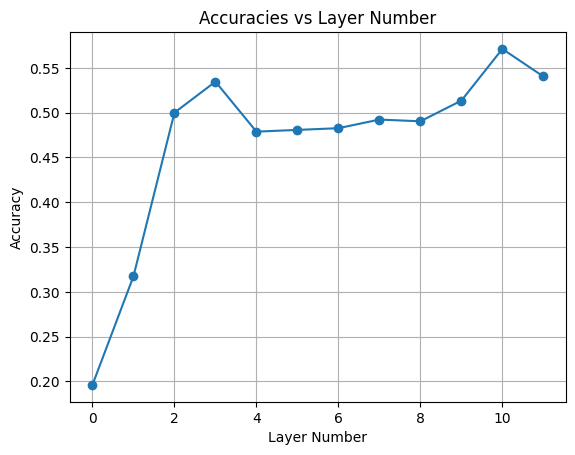

In [29]:
import matplotlib.pyplot as plt
layer_numbers = range(model.config.num_hidden_layers)
plt.plot(layer_numbers, accuracies, marker='o')
plt.xlabel('Layer Number')
plt.ylabel('Accuracy')
plt.title('Accuracies vs Layer Number')
plt.grid(True)
plt.show()

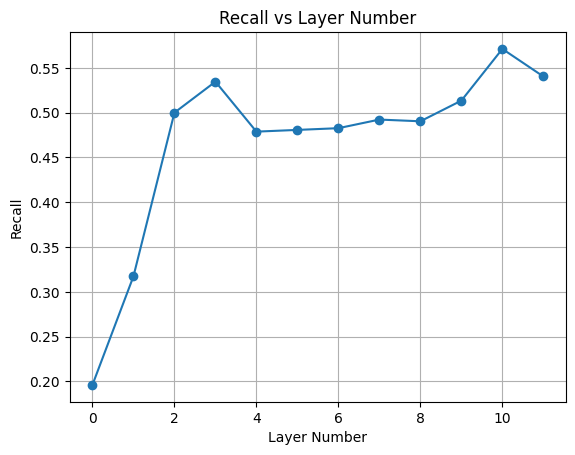

In [33]:
import matplotlib.pyplot as plt
layer_numbers = range(model.config.num_hidden_layers)
plt.plot(layer_numbers, recalls, marker='o')
plt.xlabel('Layer Number')
plt.ylabel('Recall')
plt.title('Recall vs Layer Number')
plt.grid(True)
plt.show()

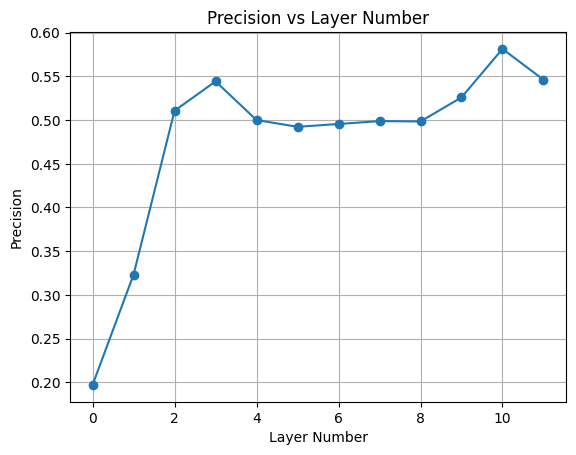

In [34]:
import matplotlib.pyplot as plt
layer_numbers = range(model.config.num_hidden_layers)
plt.plot(layer_numbers, precisions, marker='o')
plt.xlabel('Layer Number')
plt.ylabel('Precision')
plt.title('Precision vs Layer Number')
plt.grid(True)
plt.show()

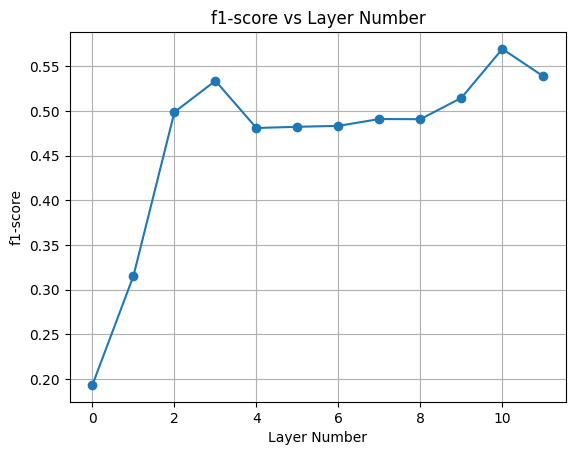

In [36]:
import matplotlib.pyplot as plt
layer_numbers = range(model.config.num_hidden_layers)
plt.plot(layer_numbers, f1s, marker='o')
plt.xlabel('Layer Number')
plt.ylabel('f1-score')
plt.title('f1-score vs Layer Number')
plt.grid(True)
plt.show()

# Custom Section

## Make a Hypothesis [5]

Based on the experiments from the previous section, come up with an intuition of how doing Language Modelling could teach the model about those aspects of spelling?

## Design an experiment [5]

Design your own probing experiment to check for an interesting subtask using spelling.

## Code up using the guidelines from the previous cells [8]

## Do layer-wise analysis on your task [4]

Do probes for particular layers do better than others?

Make a layer-wise plot


## Bonus: Design a control task for your experiment [10]

Reference: https://arxiv.org/abs/1909.03368




# Report [10]

Make a report summarizing your findings and claims

In [21]:
import random
from collections import defaultdict
def syllable_count(word):
  word = word.lower()
  count = 0
  vowels = "aeiouy"
  if word[0] in vowels:
    count += 1
  for index in range(1, len(word)):
    if word[index] in vowels and word[index - 1] not in vowels:
      count += 1
  if word.endswith("e"):
    count -= 1
  if count == 0:
    count += 1
  return count

def create_syllable_dataset(words, num_samples_per_letter):
    dataset = []
    letter_counts = defaultdict(int)

    for word in words:
        first_letter = word[0].lower()
        if letter_counts[first_letter] < num_samples_per_letter:
            letter_counts[first_letter] += 1
            dataset.append((word, syllable_count(word)))

    random.shuffle(dataset)
    return dataset

dataset = create_syllable_dataset(words_list, num_samples_per_letter=100)

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Split the dataset (consider stratified splitting for future experiments)
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=42)

print(model.config.num_hidden_layers)
accuracies = []
recalls = []
f1s = []
precisions = []

for layer_num in range(model.config.num_hidden_layers):  # Iterate through Roberta layers
    # Obtain embeddings for the train and test sets
    train_embeds = get_embeddings_all_layers(model, tokenizer, X_train, pool_func=lambda x, dim: np.mean(x, axis=dim), layer=layer_num)
    test_embeds = get_embeddings_all_layers(model, tokenizer, X_test, pool_func=lambda x, dim: np.mean(x, axis=dim), layer=layer_num)

    # concatenate the embeddings
    train_embeds = np.concatenate(train_embeds, axis=0)
    test_embeds = np.concatenate(test_embeds, axis=0)

    train_embeds = scaler.fit_transform(train_embeds)
    test_embeds = scaler.transform(test_embeds)

    # Train the classifier
    classifier = LogisticRegression(max_iter=1000)
    classifier.fit(train_embeds, [X_train[i][1] for i in range(len(X_train))])

    # Evaluate
    print(f"Layer {layer_num+1}:")
    print(classification_report([X_test[i][1] for i in range(len(X_test))], classifier.predict(test_embeds)))
    report = classification_report([X_test[i][1] for i in range(len(X_test))], classifier.predict(test_embeds), output_dict=True)
    accuracies.append(report["accuracy"])
    recalls.append(report['weighted avg']['recall'])
    f1s.append(report['weighted avg']['f1-score'])
    precisions.append(report['weighted avg']['precision'])

12
Layer 1:
              precision    recall  f1-score   support

           1       0.82      0.81      0.82        75
           2       0.79      0.82      0.80       164
           3       0.76      0.76      0.76       165
           4       0.57      0.63      0.60        79
           5       0.50      0.32      0.39        28
           6       0.67      0.25      0.36         8
           7       0.00      0.00      0.00         1

    accuracy                           0.73       520
   macro avg       0.59      0.51      0.53       520
weighted avg       0.73      0.73      0.73       520

Layer 2:
              precision    recall  f1-score   support

           1       0.85      0.83      0.84        75
           2       0.80      0.82      0.81       164
           3       0.71      0.75      0.73       165
           4       0.49      0.53      0.51        79
           5       0.56      0.36      0.43        28
           6       1.00      0.12      0.22         8
   

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Layer 3:
              precision    recall  f1-score   support

           1       0.88      0.81      0.85        75
           2       0.81      0.84      0.83       164
           3       0.74      0.81      0.77       165
           4       0.55      0.56      0.55        79
           5       0.41      0.25      0.31        28
           6       0.67      0.25      0.36         8
           7       0.00      0.00      0.00         1

    accuracy                           0.74       520
   macro avg       0.58      0.50      0.52       520
weighted avg       0.73      0.74      0.73       520



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Layer 4:
              precision    recall  f1-score   support

           1       0.93      0.83      0.87        75
           2       0.83      0.79      0.81       164
           3       0.72      0.83      0.77       165
           4       0.61      0.62      0.62        79
           5       0.55      0.39      0.46        28
           6       0.40      0.25      0.31         8
           7       0.00      0.00      0.00         1

    accuracy                           0.75       520
   macro avg       0.58      0.53      0.55       520
weighted avg       0.75      0.75      0.75       520



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Layer 5:
              precision    recall  f1-score   support

           1       0.86      0.81      0.84        75
           2       0.81      0.80      0.81       164
           3       0.75      0.80      0.77       165
           4       0.55      0.56      0.55        79
           5       0.43      0.36      0.39        28
           6       0.40      0.25      0.31         8
           7       0.00      0.00      0.00         1

    accuracy                           0.73       520
   macro avg       0.54      0.51      0.52       520
weighted avg       0.73      0.73      0.73       520



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Layer 6:
              precision    recall  f1-score   support

           1       0.79      0.77      0.78        75
           2       0.82      0.79      0.80       164
           3       0.77      0.82      0.79       165
           4       0.61      0.61      0.61        79
           5       0.45      0.46      0.46        28
           6       0.50      0.25      0.33         8
           7       0.00      0.00      0.00         1

    accuracy                           0.74       520
   macro avg       0.56      0.53      0.54       520
weighted avg       0.74      0.74      0.74       520



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels wit

Layer 7:
              precision    recall  f1-score   support

           1       0.88      0.81      0.85        75
           2       0.79      0.84      0.81       164
           3       0.76      0.79      0.77       165
           4       0.63      0.56      0.59        79
           5       0.42      0.50      0.46        28
           6       0.33      0.12      0.18         8
           7       0.00      0.00      0.00         1

    accuracy                           0.74       520
   macro avg       0.55      0.52      0.52       520
weighted avg       0.74      0.74      0.74       520



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels wit

Layer 8:
              precision    recall  f1-score   support

           1       0.90      0.75      0.82        75
           2       0.74      0.86      0.80       164
           3       0.74      0.73      0.73       165
           4       0.61      0.54      0.58        79
           5       0.41      0.43      0.42        28
           6       0.50      0.38      0.43         8
           7       0.00      0.00      0.00         1

    accuracy                           0.72       520
   macro avg       0.56      0.53      0.54       520
weighted avg       0.72      0.72      0.72       520



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels wit

Layer 9:
              precision    recall  f1-score   support

           1       0.87      0.81      0.84        75
           2       0.79      0.80      0.80       164
           3       0.69      0.73      0.71       165
           4       0.53      0.53      0.53        79
           5       0.40      0.29      0.33        28
           6       0.43      0.38      0.40         8
           7       0.00      0.00      0.00         1

    accuracy                           0.71       520
   macro avg       0.53      0.51      0.52       520
weighted avg       0.70      0.71      0.70       520



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels wit

Layer 10:
              precision    recall  f1-score   support

           1       0.89      0.79      0.84        75
           2       0.80      0.80      0.80       164
           3       0.66      0.74      0.70       165
           4       0.49      0.49      0.49        79
           5       0.43      0.36      0.39        28
           6       0.67      0.25      0.36         8
           7       0.00      0.00      0.00         1

    accuracy                           0.70       520
   macro avg       0.56      0.49      0.51       520
weighted avg       0.70      0.70      0.70       520



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels wit

Layer 11:
              precision    recall  f1-score   support

           1       0.84      0.76      0.80        75
           2       0.75      0.80      0.78       164
           3       0.68      0.71      0.69       165
           4       0.53      0.49      0.51        79
           5       0.42      0.39      0.41        28
           6       0.50      0.25      0.33         8
           7       0.00      0.00      0.00         1

    accuracy                           0.69       520
   macro avg       0.53      0.49      0.50       520
weighted avg       0.68      0.69      0.68       520

Layer 12:
              precision    recall  f1-score   support

           1       0.92      0.79      0.85        75
           2       0.77      0.81      0.79       164
           3       0.67      0.70      0.68       165
           4       0.47      0.49      0.48        79
           5       0.43      0.36      0.39        28
           6       0.40      0.25      0.31         8
    

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


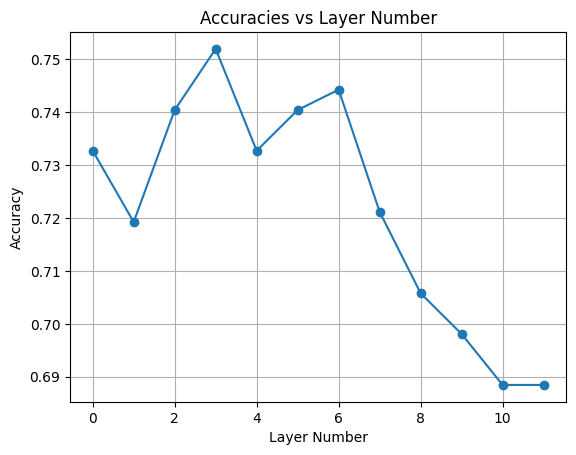

In [24]:
import matplotlib.pyplot as plt
layer_numbers = range(model.config.num_hidden_layers)
plt.plot(layer_numbers, accuracies, marker='o')
plt.xlabel('Layer Number')
plt.ylabel('Accuracy')
plt.title('Accuracies vs Layer Number')
plt.grid(True)
plt.show()

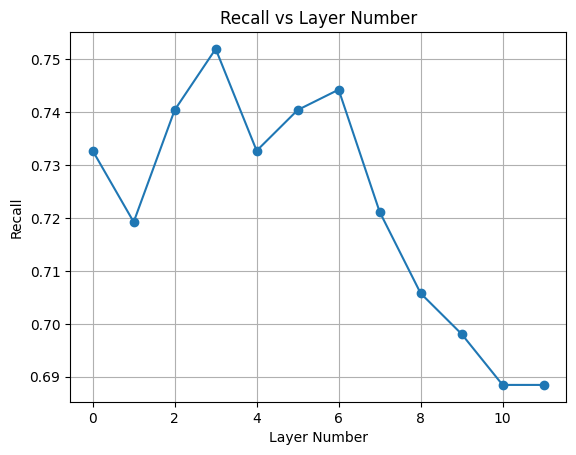

In [25]:
import matplotlib.pyplot as plt
layer_numbers = range(model.config.num_hidden_layers)
plt.plot(layer_numbers, recalls, marker='o')
plt.xlabel('Layer Number')
plt.ylabel('Recall')
plt.title('Recall vs Layer Number')
plt.grid(True)
plt.show()

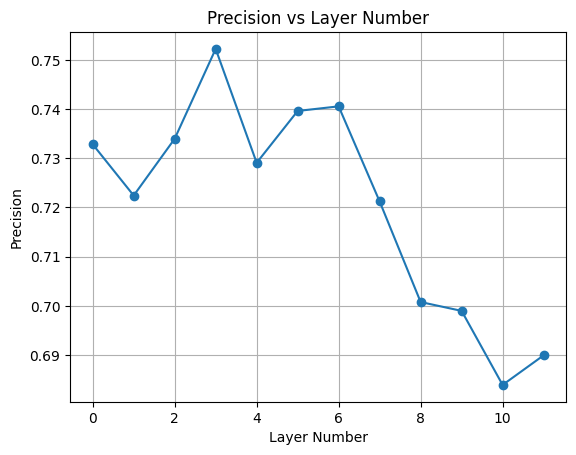

In [26]:
import matplotlib.pyplot as plt
layer_numbers = range(model.config.num_hidden_layers)
plt.plot(layer_numbers, precisions, marker='o')
plt.xlabel('Layer Number')
plt.ylabel('Precision')
plt.title('Precision vs Layer Number')
plt.grid(True)
plt.show()

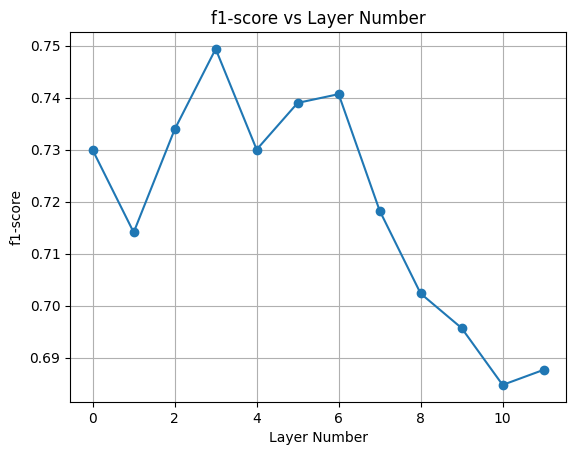

In [27]:
import matplotlib.pyplot as plt
layer_numbers = range(model.config.num_hidden_layers)
plt.plot(layer_numbers, f1s, marker='o')
plt.xlabel('Layer Number')
plt.ylabel('f1-score')
plt.title('f1-score vs Layer Number')
plt.grid(True)
plt.show()

In [ ]:
def create_control_syllable_dataset(words, num_samples_per_letter):
    dataset = []
    letter_counts = defaultdict(list)

    # Group words by their initial letter
    for word in words:
        first_letter = word[0].lower()
        letter_counts[first_letter].append(word)

    # Generate pairs of words with different syllable counts
    for letter, words_with_letter in letter_counts.items():
        if len(words_with_letter) >= 2:
            # Shuffle the words with the same initial letter
            random.shuffle(words_with_letter)
            # Take pairs of words with different syllable counts
            for i in range(0, len(words_with_letter) - 1, 2):
                word_1 = words_with_letter[i]
                word_2 = words_with_letter[i + 1]
                dataset.append((word_1, syllable_count(word_1)))
                dataset.append((word_2, syllable_count(word_2)))

    random.shuffle(dataset)
    return dataset

control_dataset = create_control_syllable_dataset(words_list, num_samples_per_letter=100)

# Split the control dataset
X_control_train, X_control_test = train_test_split(control_dataset, test_size=0.2, random_state=42)

# Perform the same process for the control task as for the syllable detection task
control_accuracies = []
control_recalls = []
control_f1s = []
control_precisions = []

for layer_num in range(model.config.num_hidden_layers):
    # Obtain embeddings for the train and test sets
    control_train_embeds = get_embeddings_all_layers(model, tokenizer, X_control_train, pool_func=lambda x, dim: np.mean(x, axis=dim), layer=layer_num)
    control_test_embeds = get_embeddings_all_layers(model, tokenizer, X_control_test, pool_func=lambda x, dim: np.mean(x, axis=dim), layer=layer_num)

    # Concatenate the embeddings
    control_train_embeds = np.concatenate(control_train_embeds, axis=0)
    control_test_embeds = np.concatenate(control_test_embeds, axis=0)

    control_train_embeds = scaler.fit_transform(control_train_embeds)
    control_test_embeds = scaler.transform(control_test_embeds)

    # Train the classifier
    classifier_control = LogisticRegression(max_iter=1000)
    classifier_control.fit(control_train_embeds, [X_control_train[i][1] for i in range(len(X_control_train))])

    # Evaluate
    print(f"Layer {layer_num+1}:")
    print(classification_report([X_control_test[i][1] for i in range(len(X_control_test))], classifier_control.predict(control_test_embeds)))
    report_control = classification_report([X_control_test[i][1] for i in range(len(X_control_test))], classifier_control.predict(control_test_embeds), output_dict=True)
    control_accuracies.append(report_control["accuracy"])
    control_recalls.append(report_control['weighted avg']['recall'])
    control_f1s.append(report_control['weighted avg']['f1-score'])
    control_precisions.append(report_control['weighted avg']['precision'])


In [ ]:
import matplotlib.pyplot as plt
layer_numbers = range(model.config.num_hidden_layers)
plt.plot(layer_numbers, accuracies, marker='o')
plt.xlabel('Layer Number')
plt.ylabel('Accuracy')
plt.title('Accuracies vs Layer Number')
plt.grid(True)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
layer_numbers = range(model.config.num_hidden_layers)
plt.plot(layer_numbers, recalls, marker='o')
plt.xlabel('Layer Number')
plt.ylabel('Recall')
plt.title('Recall vs Layer Number')
plt.grid(True)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
layer_numbers = range(model.config.num_hidden_layers)
plt.plot(layer_numbers, precisions, marker='o')
plt.xlabel('Layer Number')
plt.ylabel('Precision')
plt.title('Precision vs Layer Number')
plt.grid(True)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
layer_numbers = range(model.config.num_hidden_layers)
plt.plot(layer_numbers, f1s, marker='o')
plt.xlabel('Layer Number')
plt.ylabel('f1-score')
plt.title('f1-score vs Layer Number')
plt.grid(True)
plt.show()